In [224]:
human_genome_size = 3e9
hla_size = 3.6e6                   # classical MHC is 3.6Mb
readuntil_thresh = 250             # events, which is ~= bases
max_num_pores = 512                # only pores, i am not modeling channels
p_dna_in_pore = 0.01               # empirical, no idea what this should be
read_bases_per_second = 250        # R9
num_active_pores = 350             # out of 512
p_pore_blocked = 0.002             # empirical, after a read goes through, it might get blocked

In [176]:
p_hla = hla_size / human_genome_size
def is_hla():
    return np.random.random() < p_hla
print("Fraction of reads that will overlap HLA: {:.3g}".format(p_hla))

Fraction of reads that will hit HLA: 0.0012


In [213]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

mean: 11639, std: 15120


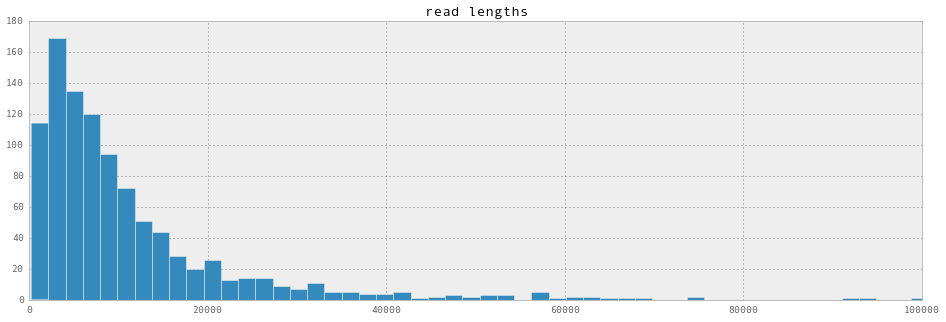

In [199]:
readlength = scipy.stats.lognorm(s=1, loc=1, scale=7000)
rv = readlength.rvs(1000)
print("mean: {:d}, std: {:d}".format(int(rv.mean()), int(rv.std())))

fig, ax = plt.subplots(1, 1, figsize=(16,5))
ax.set_xlim(0,100000)
ax.set_title("read lengths")
_ = ax.hist(rv, bins=100)

In [227]:
#@numba.jit
def run(run_hours=1, READUNTIL_HLA=False):
    BROKEN, AVAILABLE = -1, 0
    PORE, READ, IS_HLA_DNA = 0, 1, 2
    pores = np.zeros((max_num_pores,3), np.int32)
    pores[:,PORE] = BROKEN
    pores[:num_active_pores,PORE] = AVAILABLE

    total_dna_read = []
    total_hla_dna_read = []
    total_pores_blocked = 0
    total_ejected_hla = 0
    
    run_secs = int(round(run_hours * 60 * 60))

    for sec in range(run_secs):
        for n in range(pores.shape[0]):
            if pores[n,PORE] == BROKEN:
                continue

            # The Pore has pores[n,PORE] bases of DNA in it
            if pores[n,PORE] > 0: 
                bases_read_this_sec = read_bases_per_second - 10 + np.random.randint(20)
                pores[n,READ] += bases_read_this_sec
                pores[n,PORE] = pores[n,PORE] - bases_read_this_sec
                total_dna_read.append(bases_read) # a slight approximation

                # If it's not HLA, then eject it
                if READUNTIL_HLA and pores[n,IS_HLA_DNA] == 0 and pores[n,READ] > readuntil_thresh: 
                    pores[n,PORE] = AVAILABLE
                    total_ejected_hla += 1

                # End of read, reset everything
                if pores[n,PORE] == AVAILABLE or pores[n,PORE] < 0: 
                    pores[n,PORE] = AVAILABLE
                    pores[n,READ] = 0
                    pores[n,IS_HLA_DNA] = 0

                    # After each read ends, there is a chance to get blocked
                    if np.random.random() < p_pore_blocked:
                        pores[n,PORE] = BROKEN
                        total_pores_blocked += 1

            # Pore is empty, check for new DNA
            if pores[n,PORE] == AVAILABLE:
                if np.random.random() < p_dna_in_pore: 
                    pores[n,PORE] = int(readlength.rvs())

                    if READUNTIL_HLA and is_hla():
                        total_hla_dna_read.append(pores[n,PORE]) # slight approximation
                        pores[n,IS_HLA_DNA] = 1

            assert pores[n,PORE] >= -1 and pores[n,READ] >= 0, pores[n]
    
    print("End of experiment after {:.1f} hours".format(run_hours))
    print("Total DNA read: {:d} bases ({:.1f} Mb)".format(sum(total_dna_read), sum(total_dna_read)/1e6))
    print("Total pores blocked: {:d} / {:d}".format(total_pores_blocked, num_active_pores))
    if READUNTIL_HLA:
        print("HLA\n---")
        print("Total HLA DNA read: {:d} ({:.1f} Mb) in {:d} reads".format(sum(total_hla_dna_read),
                                                                          sum(total_hla_dna_read)/1e6, 
                                                                          len(total_hla_dna_read)))
        print("Total reads ejected for not being HLA: {:d}".format(total_ejected_hla))

In [229]:
run(run_hours=1, READUNTIL_HLA=False)

End of experiment after 1.0 hours
Total DNA read: 93374486 bases (93.4 Mb)
Total pores blocked: 17 / 350


In [222]:
run(run_hours=2, READUNTIL_HLA=False)

End of experiment after 2.0 hours
Total DNA read: 282206020 bases (282.2 Mb)
Total pores blocked: 49 / 350


In [223]:
run(run_hours=2, READUNTIL_HLA=True)

End of experiment after 2.0 hours
Total DNA read: 17274535 bases (17.3 Mb)
Total pores blocked: 91 / 350
HLA
---
Total HLA DNA read: 593109 in 51 reads
Total reads ejected for not being HLA: 43189
